In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics, cross_validation

In [74]:
df = pd.read_csv('household_power_consumption.txt', sep=';',
                   parse_dates={'data': ['Date', 'Time']},
                   infer_datetime_format=True,
                   na_values=['nan', '?'],
                   index_col='data')

In [75]:
print(df.shape)
df.head()

(2075259, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
data,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [76]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [77]:
for i in range(7):
    df.iloc[:, i] = df.iloc[:, i].fillna(df.iloc[:, i].mean())

In [78]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [79]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [80]:
df_daily = df.resample('D').mean()

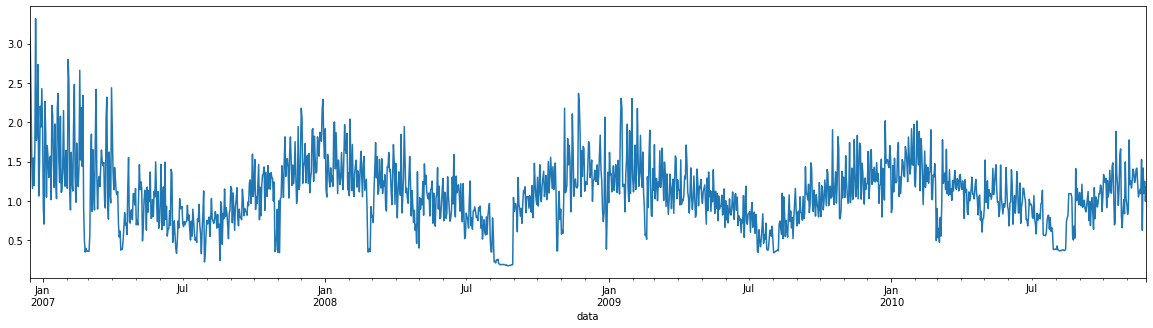

In [81]:
plt.figure(figsize=(20, 5))
df_daily.Global_active_power.plot()
plt.show()

In [82]:
scaler = MinMaxScaler()
df_daily = pd.DataFrame(scaler.fit_transform(df_daily), columns=df_daily.columns, index=df_daily.index)

In [83]:
df_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
data,,,,,,,
2006-12-16,0.916786,0.130732,0.315385,0.928499,0.000000,0.163965,0.740357
2006-12-17,0.694252,0.426671,0.550494,0.695226,0.181857,0.345776,0.536762
2006-12-18,0.431901,0.234750,0.620518,0.424618,0.095088,0.216451,0.566912
2006-12-19,0.313037,0.202322,0.667476,0.311508,0.075051,0.627798,0.218615
2006-12-20,0.436748,0.232377,0.686364,0.428075,0.000000,0.218680,0.568916


In [84]:
corr, _ = pearsonr(df.Global_active_power, df.Global_reactive_power)
print('Pearson Correlation: %.2f' %corr)

Pearson Correlation: 0.25


In [85]:
corr, _ = pearsonr(df.Voltage, df.Global_intensity)
print('Pearson Correlation: %.2f' %corr)

Pearson Correlation: -0.41


In [86]:
train = df_daily.iloc[:-365]
test = df_daily.iloc[-365:]

In [87]:
train['date'] = train.index
train = train.rename(columns={'date': 'ds', 'Global_active_power': 'y'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)
forecast.shape

(1442, 19)

In [90]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-12-16,0.345230,0.400192,0.654071,0.345230,0.345230,0.184902,0.184902,0.184902,0.058139,0.058139,0.058139,0.126763,0.126763,0.126763,0.0,0.0,0.0,0.530132
1,2006-12-17,0.344863,0.393984,0.638303,0.344863,0.344863,0.178791,0.178791,0.178791,0.049785,0.049785,0.049785,0.129006,0.129006,0.129006,0.0,0.0,0.0,0.523654
2,2006-12-18,0.344495,0.305414,0.565268,0.344495,0.344495,0.094943,0.094943,0.094943,-0.036354,-0.036354,-0.036354,0.131297,0.131297,0.131297,0.0,0.0,0.0,0.439438
3,2006-12-19,0.344127,0.343038,0.588715,0.344127,0.344127,0.126417,0.126417,0.126417,-0.007135,-0.007135,-0.007135,0.133552,0.133552,0.133552,0.0,0.0,0.0,0.470545
4,2006-12-20,0.343760,0.353870,0.603077,0.343760,0.343760,0.129617,0.129617,0.129617,-0.006070,-0.006070,-0.006070,0.135687,0.135687,0.135687,0.0,0.0,0.0,0.473377


In [92]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [93]:
mean_absolute_percentage_error(test.Global_active_power, forecast[-365:].yhat)

26.95871924684511

In [94]:
mean_squared_error(test.Global_active_power, forecast[-365:].yhat, squared=False)

0.08264808648396202

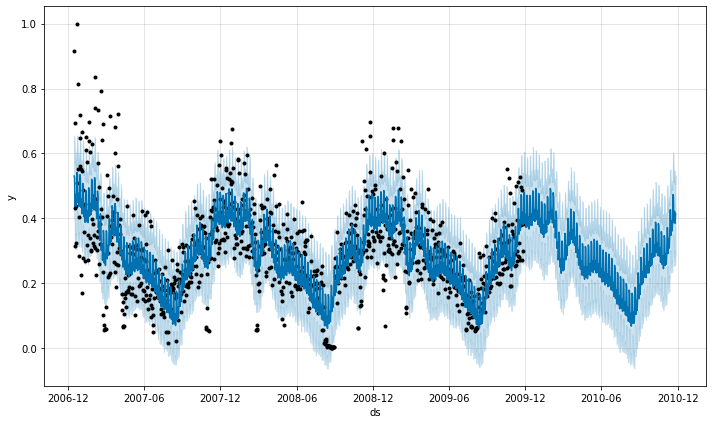

In [91]:
model.plot(forecast)
plt.show()